In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector, FactorVector, globalenv

In [2]:
# Call R
lme4 = importr('lme4')
base = importr('base')
stats = importr('stats')
lmerTest = importr('lmerTest')

In [5]:
# Files
previous, current = os.path.split(os.getcwd())
dname = previous[0:-5] 
fname_words = dname+ '\\data\\all_subjects_words_GPT2_big.pkl'
fname_sentences = dname+'\\data\\all_subjects_sentences_GPT2_big.pkl'
# get words and sentences data
df_words = pickle.load(open(fname_words, 'rb'))
df_sentences = pickle.load(open(fname_sentences, 'rb'))

In [6]:
# fit two different GLMMs to words and sentences data

glmms = []
for i, (df, weight) in enumerate(zip((df_words, df_sentences), (1, 7))):
    
    # Declare variables in R environment
    globalenv["score"] = FloatVector(df['score'].ravel())                               # actual comprehension score
    globalenv["vitesse"] = FactorVector(np.array(df['vitesse'], dtype=np.str).ravel())  # presentation speed
    globalenv["suj"] = FactorVector(np.array(df['suj'], dtype=np.str).ravel())          # subject id
    globalenv["syll_rate"] = FloatVector(df['syll_rate'].ravel())                       # syllabic rate
    globalenv["phon_rate"] = FloatVector(df['phon_rate'].ravel())                       # phonemic rate
    globalenv["syir_rate"] = FloatVector(df['syir_rate'].ravel())                       # syllabic information rate
    globalenv["phir_rate"] = FloatVector(df['phir_rate'].ravel())                       # phonemic information rate
    globalenv["stat_surp"] = FloatVector(df['stat_surp'].ravel())                       # static lexical surprise rate
    globalenv["ctxt_surp_BERT"] = FloatVector(df['ctxt_surp_BERT'].ravel())                       # contextual lexical surprise
    globalenv["ctxt_surp_GPT2_big"] = FloatVector(df['ctxt_surp_GPT2_big'].ravel())                       # contextual lexical surprise
    globalenv["peak_env"] = FloatVector(df['peak_env'].ravel())                         # acoustic modulation rate
    globalenv["weights"] = FloatVector(np.ones(df['score'].shape).ravel() * weight)     # weight argument for the GLMM
    
    #         " + scale(ctxt_surp_GPT2_big, center = TRUE, scale = TRUE)" + \
    # Fit GLMM for words data
    if i == 0:
        formula = "score ~ " + \
        "   scale(peak_env,  center = TRUE, scale = TRUE)" + \
        " + scale(phon_rate, center = TRUE, scale = TRUE)" + \
        " + scale(syll_rate, center = TRUE, scale = TRUE)" + \
        " + scale(phir_rate, center = TRUE, scale = TRUE)" + \
        " + scale(stat_surp, center = TRUE, scale = TRUE)" + \
        " + (1|vitesse) + (1|suj)"
        
    # Fit GLMM for sentences data
    if i == 1:
        formula = "score ~ " + \
        "   scale(peak_env,  center = TRUE, scale = TRUE)" + \
        " + scale(phon_rate, center = TRUE, scale = TRUE)" + \
        " + scale(syll_rate, center = TRUE, scale = TRUE)" + \
        " + scale(phir_rate, center = TRUE, scale = TRUE)" + \
        " + scale(syir_rate, center = TRUE, scale = TRUE)" + \
        " + scale(stat_surp, center = TRUE, scale = TRUE)" + \
        " + scale(ctxt_surp_GPT2_big, center = TRUE, scale = TRUE)" + \
        " + (1|vitesse) + (1|suj)"
    print(formula)
    m = lme4.glmer(formula, family='binomial', weights=globalenv["weights"])
    glmms.append(m)

score ~    scale(peak_env,  center = TRUE, scale = TRUE) + scale(phon_rate, center = TRUE, scale = TRUE) + scale(syll_rate, center = TRUE, scale = TRUE) + scale(phir_rate, center = TRUE, scale = TRUE) + scale(stat_surp, center = TRUE, scale = TRUE) + (1|vitesse) + (1|suj)
score ~    scale(peak_env,  center = TRUE, scale = TRUE) + scale(phon_rate, center = TRUE, scale = TRUE) + scale(syll_rate, center = TRUE, scale = TRUE) + scale(phir_rate, center = TRUE, scale = TRUE) + scale(syir_rate, center = TRUE, scale = TRUE) + scale(stat_surp, center = TRUE, scale = TRUE) + scale(ctxt_surp_GPT2_big, center = TRUE, scale = TRUE) + (1|vitesse) + (1|suj)


In [7]:
n_variables = 8
variable_names = [
    r'Intercept',
    r'Acoustic modulation rate ($s^{-1}$)',
    r'Phonemic rate ($s^{-1}$)',
    r'Syllabic rate ($s^{-1}$)',
    r'Phonemic information ($bit.s^{-1}$)',
    r'Syllabic information ($bit.s^{-1}$)', 
    r'Static lexical surprise ($bit.s^{-1}$)',
    r'Contextual lexical surprise ($bit.s^{-1}$)'
]

In [8]:
colors = ['grey','#e41a1c', '#ff7f00','#efca08',  '#4daf4a', '#377eb8', 'darkorchid']
titles = [r'$\it{Experiment\ 1}$' + "\n" + r'$\bf{Words}$', 
          r'$\it{Experiment\ 2}$' + "\n" + r'$\bf{Sentences}$']

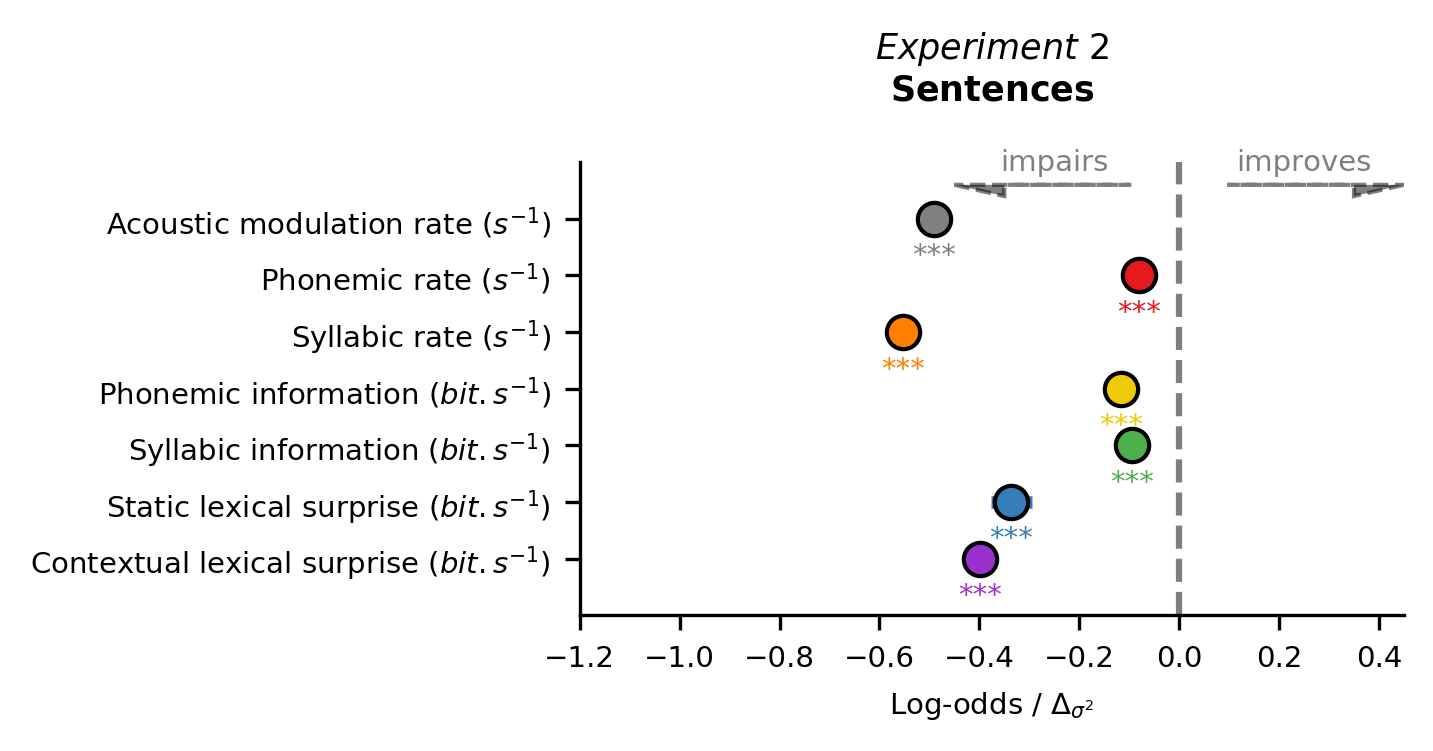

In [10]:
figsup2, ax = plt.subplots(1,1, figsize=(7.09/2, 2), facecolor='w', dpi=300)
plt.rcParams["font.size"] = "7"

all_coef = []
all_se = []

# Get model coefficients
coefs = np.array(base.summary(glmms[1])[9])[:, 0]
se = np.array(base.summary(glmms[1])[9])[:, 1]
pvals = np.array(base.summary(glmms[1])[9])[:, 3]

# Plot
for j, color in zip(np.arange(1, n_variables), colors): # Remove intercept 

    # Plot points + se
    markerfacecolor = color
    ax.errorbar(coefs[j], y=j, xerr=se[j], marker='o', 
                elinewidth=3, linewidth=0.5, color=color, 
                markerfacecolor=markerfacecolor, markeredgecolor='k', ms=8)
    all_coef.append(coefs[j])
    all_se.append(se[j])
    # Plot * of p-values
    txt = '' if pvals[j] > 0.05 else ('*' if pvals[j] > 0.01 else ('**' if pvals[j] > 0.001 else '***'))
    ax.annotate(txt, (coefs[j], j+0.65), va='center', ha='center', color=color)

# Aesthetics
ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_ylim(n_variables, 0)
ax.set_xlim(-1.2, 0.45)
ax.set_xlabel('Log-odds / $\Delta_{\sigma^2}$')
ax.set_title(titles[1], fontweight='bold', pad=15)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks(np.arange(1, n_variables))

ax.set_yticklabels(variable_names[1:])

# Arrows
l = 0.25
x = 0
y = 0.4
hw = 0.4
hl = 0.1
offset = 0.1
ax.arrow(x + offset, y, l, 0, head_width=hw, shape='right', head_length=hl, 
         color='k', linestyle='--', alpha=0.5)
ax.arrow(x - offset, y, -l, 0, head_width=hw, shape='left', head_length=hl, 
         color='k', linestyle='--', alpha=0.5)
ax.annotate('improves', (x + l, y - 0.4), va='center', ha='center', alpha=0.5)
ax.annotate('impairs', (x - l, y - 0.4), va='center', ha='center', alpha=0.5);

In [ ]:
#figsup2.savefig(dname+"\\figures\\Figure_supp2.png", dpi=300, bbox_inches='tight')